Python version: 3.8.5<br>
Pandas version: 1.5.0<br>
Sklearn version: 1.0.2<br>
xgboost version: 1.7.4<br>
Matplotlib version: 3.6.2<br>
Prophet version: 1.1.5<br>
Statsmodels version: 0.13.5

In [270]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas import to_datetime
from dateutil.relativedelta import relativedelta


In [271]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from matplotlib import pyplot
from IPython.display import display
init_notebook_mode(connected=True)  # Only needed if using Jupyter Notebook
import seaborn as sns


In [272]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb

from prophet import Prophet


In [273]:
#If missing imports above uncomment code below and fill in name of imnport

# pip install NAME_GOES HERE

In [274]:
import warnings
warnings.filterwarnings("ignore")

In [275]:
data= pd.read_csv('sample_data.csv')
data

,PRODUCT,STORE,WEEK_START_DATE,QUANTITY
0,Model-1,Store-1,1/20/2019,11
1,Model-1,Store-1,1/27/2019,43
2,Model-1,Store-1,2/10/2019,4
3,Model-1,Store-1,2/17/2019,46
4,Model-1,Store-1,2/24/2019,22
...,...,...,...,...
1271,Model-9,Store-4,8/27/2023,36
1272,Model-9,Store-4,9/17/2023,185
1273,Model-9,Store-4,10/1/2023,1
1274,Model-9,Store-4,1/28/2024,79


In [276]:
type(data['WEEK_START_DATE'][0])

str

In [277]:
#Convert date from str-> datetime
data['WEEK_START_DATE'] = pd.to_datetime(data['WEEK_START_DATE'], format='%m/%d/%Y')
type(data['WEEK_START_DATE'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [278]:
data['WEEK_START_DATE'].describe()

count                    1276
unique                    294
top       2021-10-03 00:00:00
freq                       11
first     2019-01-06 00:00:00
last      2024-02-11 00:00:00
Name: WEEK_START_DATE, dtype: object

In [279]:
data[data['WEEK_START_DATE'].dt.year == 2024]

,PRODUCT,STORE,WEEK_START_DATE,QUANTITY
1180,Model-4,Store-4,2024-01-28,11
1181,Model-4,Store-4,2024-02-11,29
1274,Model-9,Store-4,2024-01-28,79
1275,Model-9,Store-4,2024-02-11,29


In [280]:
#Remove row out of desired date range
data = data[data['WEEK_START_DATE'].dt.year != 2024]
data[data['WEEK_START_DATE'].dt.year == 2024]

,PRODUCT,STORE,WEEK_START_DATE,QUANTITY


In [281]:
if 'MONTH_YEAR' not in data:
    data['MONTH_YEAR'] = data['WEEK_START_DATE'].dt.strftime('%Y-%m')
else:
    print('Column Exists')
data

,PRODUCT,STORE,WEEK_START_DATE,QUANTITY,MONTH_YEAR
0,Model-1,Store-1,2019-01-20,11,2019-01
1,Model-1,Store-1,2019-01-27,43,2019-01
2,Model-1,Store-1,2019-02-10,4,2019-02
3,Model-1,Store-1,2019-02-17,46,2019-02
4,Model-1,Store-1,2019-02-24,22,2019-02
...,...,...,...,...,...
1269,Model-9,Store-4,2023-07-23,53,2023-07
1270,Model-9,Store-4,2023-07-30,1,2023-07
1271,Model-9,Store-4,2023-08-27,36,2023-08
1272,Model-9,Store-4,2023-09-17,185,2023-09


In [282]:
# Combine Product Store columns
data['Model_Store_Pair'] = data['PRODUCT'] +'_'+ data['STORE']
data

,PRODUCT,STORE,WEEK_START_DATE,QUANTITY,MONTH_YEAR,Model_Store_Pair
0,Model-1,Store-1,2019-01-20,11,2019-01,Model-1_Store-1
1,Model-1,Store-1,2019-01-27,43,2019-01,Model-1_Store-1
2,Model-1,Store-1,2019-02-10,4,2019-02,Model-1_Store-1
3,Model-1,Store-1,2019-02-17,46,2019-02,Model-1_Store-1
4,Model-1,Store-1,2019-02-24,22,2019-02,Model-1_Store-1
...,...,...,...,...,...,...
1269,Model-9,Store-4,2023-07-23,53,2023-07,Model-9_Store-4
1270,Model-9,Store-4,2023-07-30,1,2023-07,Model-9_Store-4
1271,Model-9,Store-4,2023-08-27,36,2023-08,Model-9_Store-4
1272,Model-9,Store-4,2023-09-17,185,2023-09,Model-9_Store-4


In [283]:
def add_seasons(df):
    # Convert 'MONTH_YEAR' to datetime
    df['MONTH_YEAR'] = pd.to_datetime(df['MONTH_YEAR'], format='%Y-%m')

    # Define a mapping of months to four seasons
    seasons_mapping = {
        3: 'Spring',
        4: 'Spring',
        5: 'Spring',
        6: 'Summer',
        7: 'Summer',
        8: 'Summer',
        9: 'Fall',
        10: 'Fall',
        11: 'Fall',
        12: 'Winter',
        1: 'Winter',
        2: 'Winter',
    }

    # Create the 'seasons' column based on the 'MONTH_YEAR' column using assign
    df = df.assign(Seasons=df['MONTH_YEAR'].dt.month.map(seasons_mapping))

    return df


In [284]:
#Staging Table to export for dashboard
staging_table = add_seasons(data)
staging_table.to_csv('staging_table.csv', index=False)
staging_table

,PRODUCT,STORE,WEEK_START_DATE,QUANTITY,MONTH_YEAR,Model_Store_Pair,Seasons
0,Model-1,Store-1,2019-01-20,11,2019-01-01,Model-1_Store-1,Winter
1,Model-1,Store-1,2019-01-27,43,2019-01-01,Model-1_Store-1,Winter
2,Model-1,Store-1,2019-02-10,4,2019-02-01,Model-1_Store-1,Winter
3,Model-1,Store-1,2019-02-17,46,2019-02-01,Model-1_Store-1,Winter
4,Model-1,Store-1,2019-02-24,22,2019-02-01,Model-1_Store-1,Winter
...,...,...,...,...,...,...,...
1269,Model-9,Store-4,2023-07-23,53,2023-07-01,Model-9_Store-4,Summer
1270,Model-9,Store-4,2023-07-30,1,2023-07-01,Model-9_Store-4,Summer
1271,Model-9,Store-4,2023-08-27,36,2023-08-01,Model-9_Store-4,Summer
1272,Model-9,Store-4,2023-09-17,185,2023-09-01,Model-9_Store-4,Fall


### Statistical Analysis

In [285]:
# Group data by Model/Store
group = staging_table.groupby('Model_Store_Pair')

# Calculate statistical information
product_stats = group['QUANTITY'].describe()

product_stats


,count,mean,std,min,25%,50%,75%,max
Model_Store_Pair,,,,,,,,
Model-10_Store-9,221.0,34.171946,100.006169,1.0,4.00,11.0,22.00,906.0
Model-11_Store-10,10.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
Model-12_Store-11,167.0,2.574850,2.013231,1.0,1.00,2.0,3.00,13.0
Model-13_Store-12,53.0,2.264151,1.820302,1.0,1.00,2.0,3.00,9.0
Model-14_Store-13,6.0,1.333333,0.816497,1.0,1.00,1.0,1.00,3.0
Model-15_Store-14,8.0,6.750000,8.860023,1.0,1.75,5.0,5.50,28.0
Model-16_Store-15,36.0,13.861111,13.751162,1.0,3.75,10.0,19.00,58.0
Model-17_Store-16,9.0,25.222222,19.331178,1.0,18.00,21.0,30.00,70.0
Model-18_Store-17,162.0,4.790123,8.084516,1.0,2.00,3.0,5.00,65.0


In [286]:
group = staging_table.groupby('Model_Store_Pair')

def seasonal_analysis(model_store):
    store_data = group.get_group(model_store)
    if len(store_data) < 24:
        print(f"Model-Store {model_store} has less than 24 data points, unable to perform seasonal analysis.")
    else:
        decomposition = seasonal_decompose(store_data['QUANTITY'], model='additive', period=12)
        decomposition.plot()
        fig = plt.gcf()
        fig.set_size_inches(12, 8)
        plt.title(f'Decomposition for {model_store}')
        plt.xlabel('Date')
        plt.show()


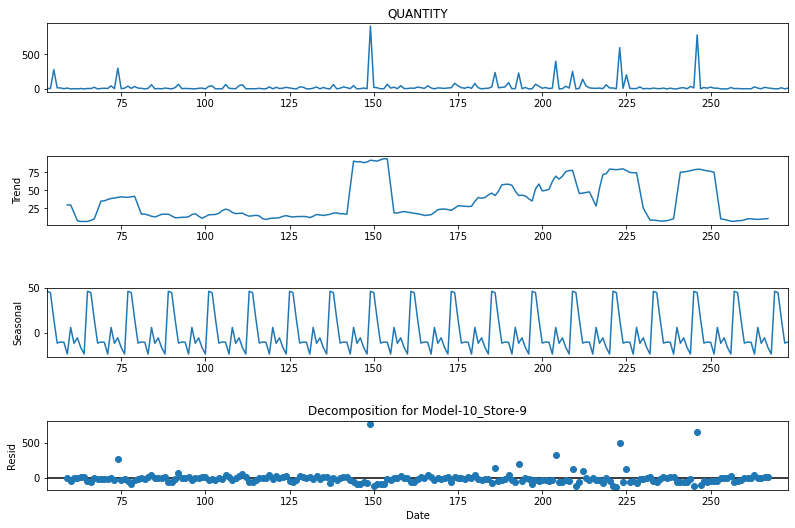

In [287]:
model_store= 'Model-10_Store-9' #put in any model store to view plots
seasonal_analysis(model_store)

In [288]:
sales_data = data.groupby(['Model_Store_Pair','MONTH_YEAR']).sum().reset_index()
sales_data

,Model_Store_Pair,MONTH_YEAR,QUANTITY
0,Model-10_Store-9,2019-01-01,311
1,Model-10_Store-9,2019-02-01,38
2,Model-10_Store-9,2019-03-01,9
3,Model-10_Store-9,2019-04-01,40
4,Model-10_Store-9,2019-05-01,75
...,...,...,...
470,Model-9_Store-4,2023-06-01,11
471,Model-9_Store-4,2023-07-01,57
472,Model-9_Store-4,2023-08-01,36
473,Model-9_Store-4,2023-09-01,185


In [289]:
model_store_pairs = ['Model-1/Store-1', 'Model-2/Store-2', 'Model-8/Store-8',
        'Model-10/Store-9', 'Model-14/Store-13', 'Model-12/Store-11',
        'Model-17/Store-16', 'Model-16/Store-15'] #These are the requested model_store_pairs to make predictions on

# Replace slash ("/") with underscore ("_") in model/store pairs
model_store_pairs = [pair.replace('/', '_') for pair in model_store_pairs]

# Group the data by 'Model_Store_Pair' and count the rows
grouped_counts = sales_data.groupby(['Model_Store_Pair']).size().reset_index(name='Count')

grouped_counts

,Model_Store_Pair,Count
0,Model-10_Store-9,57
1,Model-11_Store-10,8
2,Model-12_Store-11,47
3,Model-13_Store-12,26
4,Model-14_Store-13,4
5,Model-15_Store-14,7
6,Model-16_Store-15,27
7,Model-17_Store-16,9
8,Model-18_Store-17,47
9,Model-1_Store-1,25


In [290]:
# Removing mode/stores with less than 10 entries unless it's in the requested set above (model_store_pair)

# Define the threshold for the minimum number of rows
threshold = 10

# Group the data by 'Model_Store_Pair' and count the rows
grouped_counts = sales_data['Model_Store_Pair'].value_counts()

# Get the Model/Store pairs that have at least 10 rows
valid_pairs = grouped_counts[grouped_counts >= threshold].index.tolist()

# Filter the DataFrame to keep rows with valid Model/Store pairs or specified pairs
sales_data = sales_data[
    (sales_data['Model_Store_Pair'].isin(valid_pairs)) |
    (sales_data['Model_Store_Pair'].isin(model_store_pairs))
]

sales_data


,Model_Store_Pair,MONTH_YEAR,QUANTITY
0,Model-10_Store-9,2019-01-01,311
1,Model-10_Store-9,2019-02-01,38
2,Model-10_Store-9,2019-03-01,9
3,Model-10_Store-9,2019-04-01,40
4,Model-10_Store-9,2019-05-01,75
...,...,...,...
470,Model-9_Store-4,2023-06-01,11
471,Model-9_Store-4,2023-07-01,57
472,Model-9_Store-4,2023-08-01,36
473,Model-9_Store-4,2023-09-01,185


In [291]:
# Group the data by 'Model_Store_Pair' and count the rows
grouped_counts = sales_data.groupby(['Model_Store_Pair']).size().reset_index(name='Count')

grouped_counts

,Model_Store_Pair,Count
0,Model-10_Store-9,57
1,Model-12_Store-11,47
2,Model-13_Store-12,26
3,Model-14_Store-13,4
4,Model-16_Store-15,27
5,Model-17_Store-16,9
6,Model-18_Store-17,47
7,Model-1_Store-1,25
8,Model-21_Store-20,12
9,Model-2_Store-2,53


In [292]:
# Get unique Model_Store_Pairs
unique_pairs = sales_data['Model_Store_Pair'].unique()

plot_data = []

# Loop through each unique Model_Store_Pair and create a trace
for unique_pair in unique_pairs:
    trace = go.Scatter(
        x=sales_data[sales_data['Model_Store_Pair'] == unique_pair]['MONTH_YEAR'],
        y=sales_data[sales_data['Model_Store_Pair'] == unique_pair]['QUANTITY'],
        mode='lines+markers',
        name=unique_pair  # Label each trace with the Model_Store_Pair
    )
    plot_data.append(trace)

plot_layout = go.Layout(
    title='Monthly Sales Quantity'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### Adding missing values

In [293]:
# Method 1: Seasonal Imputation

def add_missing_months_with_monthly_average(data):

    # Convert MONTH_YEAR to datetime
    data['MONTH_YEAR'] = pd.to_datetime(data['MONTH_YEAR'])

    # Get unique Model_Store_Pairs
    model_store_pairs = data['Model_Store_Pair'].unique()

    # Create a template DataFrame with all possible MONTH_YEAR values
    all_months = pd.date_range(start=data['MONTH_YEAR'].min(), end=data['MONTH_YEAR'].max(), freq='MS')
    template = pd.DataFrame({
        'MONTH_YEAR': all_months
    })

    # Create a cross-join to cover all model-store pairs
    template['key'] = 1
    cross_join = pd.DataFrame({'key': 1, 'Model_Store_Pair': model_store_pairs})
    result = pd.merge(cross_join, template, on='key').drop(columns='key')

    # Merge with the original data to fill in missing months
    result = pd.merge(result, data, on=['Model_Store_Pair', 'MONTH_YEAR'], how='left')

    # Sort the result DataFrame by Model_Store_Pair and MONTH_YEAR
    result = result.sort_values(by=['Model_Store_Pair', 'MONTH_YEAR']).reset_index(drop=True)

    # Calculate the monthly average for each Model_Store_Pair
    result['QUANTITY'] = result.groupby(['Model_Store_Pair', result['MONTH_YEAR'].dt.month])['QUANTITY'].transform(lambda x: x.fillna(x.mean()))

    # Convert MONTH_YEAR back to its original format (yyyy-mm)
    result['MONTH_YEAR'] = result['MONTH_YEAR'].dt.strftime('%Y-%m')

    return result



In [294]:
# Method 2: Interpolation

def add_missing_months_with_monthly_interpolation(data):
    # Convert MONTH_YEAR to datetime
    data['MONTH_YEAR'] = pd.to_datetime(data['MONTH_YEAR'])

    # Get unique Model_Store_Pairs
    model_store_pairs = data['Model_Store_Pair'].unique()

    # Create a template DataFrame with all possible MONTH_YEAR values
    all_months = pd.date_range(start=data['MONTH_YEAR'].min(), end=data['MONTH_YEAR'].max(), freq='MS')
    template = pd.DataFrame({
        'MONTH_YEAR': all_months
    })

    # Create a cross-join to cover all model-store pairs
    template['key'] = 1
    cross_join = pd.DataFrame({'key': 1, 'Model_Store_Pair': model_store_pairs})
    result = pd.merge(cross_join, template, on='key').drop(columns='key')

    # Merge with the original data to fill in missing months
    result = pd.merge(result, data, on=['Model_Store_Pair', 'MONTH_YEAR'], how='left')

    # Sort the result DataFrame by Model_Store_Pair and MONTH_YEAR
    result = result.sort_values(by=['Model_Store_Pair', 'MONTH_YEAR']).reset_index(drop=True)

    # Perform interpolation for missing values
    #['linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric', 'krogh', 'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline']

    result['QUANTITY'] = result.groupby('Model_Store_Pair')['QUANTITY'].apply(lambda group: group.interpolate(method='linear'))

    # Convert MONTH_YEAR back to its original format (yyyy-mm)
    result['MONTH_YEAR'] = result['MONTH_YEAR'].dt.strftime('%Y-%m')

    return result


In [295]:
full_sales_df = add_missing_months_with_monthly_average(sales_data)
full_sales_df.fillna(0,inplace=True)
full_sales_df['MONTH_YEAR'] = pd.to_datetime(full_sales_df['MONTH_YEAR'])
full_sales_df = full_sales_df[full_sales_df['MONTH_YEAR']<'2023-11-01']
full_sales_df

,Model_Store_Pair,MONTH_YEAR,QUANTITY
0,Model-10_Store-9,2019-01-01,311.0
1,Model-10_Store-9,2019-02-01,38.0
2,Model-10_Store-9,2019-03-01,9.0
3,Model-10_Store-9,2019-04-01,40.0
4,Model-10_Store-9,2019-05-01,75.0
...,...,...,...
893,Model-9_Store-4,2023-06-01,11.0
894,Model-9_Store-4,2023-07-01,57.0
895,Model-9_Store-4,2023-08-01,36.0
896,Model-9_Store-4,2023-09-01,185.0


In [296]:
unique_pairs = sales_data['Model_Store_Pair'].unique()

# Use factorize to create unique IDs for each pair
pair_ids, pair_labels = pd.factorize(unique_pairs)

# Create a DataFrame to map pairs to IDs
pair_id_mapping = pd.DataFrame({'Model_Store_Pair': unique_pairs, 'Pair_ID': pair_ids})
pair_id_mapping

,Model_Store_Pair,Pair_ID
0,Model-10_Store-9,0
1,Model-12_Store-11,1
2,Model-13_Store-12,2
3,Model-14_Store-13,3
4,Model-16_Store-15,4
5,Model-17_Store-16,5
6,Model-18_Store-17,6
7,Model-1_Store-1,7
8,Model-21_Store-20,8
9,Model-2_Store-2,9


In [297]:
full_sales_df['Model_Store_Pair_ID'] = full_sales_df['Model_Store_Pair'].map(pair_id_mapping.set_index('Model_Store_Pair')['Pair_ID'])
full_sales_df

,Model_Store_Pair,MONTH_YEAR,QUANTITY,Model_Store_Pair_ID
0,Model-10_Store-9,2019-01-01,311.0,0
1,Model-10_Store-9,2019-02-01,38.0,0
2,Model-10_Store-9,2019-03-01,9.0,0
3,Model-10_Store-9,2019-04-01,40.0,0
4,Model-10_Store-9,2019-05-01,75.0,0
...,...,...,...,...
893,Model-9_Store-4,2023-06-01,11.0,14
894,Model-9_Store-4,2023-07-01,57.0,14
895,Model-9_Store-4,2023-08-01,36.0,14
896,Model-9_Store-4,2023-09-01,185.0,14


In [298]:
# Staging Table to export for dashboard
staging_table_full_sales_df= add_seasons(full_sales_df)
staging_table_full_sales_df.to_csv('staging_table_full_sales_df.csv', index=False)
staging_table_full_sales_df

,Model_Store_Pair,MONTH_YEAR,QUANTITY,Model_Store_Pair_ID,Seasons
0,Model-10_Store-9,2019-01-01,311.0,0,Winter
1,Model-10_Store-9,2019-02-01,38.0,0,Winter
2,Model-10_Store-9,2019-03-01,9.0,0,Spring
3,Model-10_Store-9,2019-04-01,40.0,0,Spring
4,Model-10_Store-9,2019-05-01,75.0,0,Spring
...,...,...,...,...,...
893,Model-9_Store-4,2023-06-01,11.0,14,Summer
894,Model-9_Store-4,2023-07-01,57.0,14,Summer
895,Model-9_Store-4,2023-08-01,36.0,14,Summer
896,Model-9_Store-4,2023-09-01,185.0,14,Fall


### Check if Data is Stationary

In [299]:
# Ensure the data is in time series format and is sorted by date
data = full_sales_df['QUANTITY']

# Check stationarity using the Dickey-Fuller test
result = adfuller(data)
if result[1] > 0.05:
    print("Data is not stationary. Perform differencing.")
    data_diff = data - data.shift(1)
    data_diff.dropna(inplace=True)
else:
    print("Data is stationary.")
    data_diff = data


Data is stationary.


In [300]:
# Visualizing the dataset with added values which will be used for model trainig
# Get unique Model_Store_Pairs
unique_pairs = full_sales_df['Model_Store_Pair'].unique()

# Create an empty list to store traces
plot_data = []

# Loop through each unique Model_Store_Pair and create a trace
for unique_pair in unique_pairs:
    trace = go.Scatter(
        x=full_sales_df[full_sales_df['Model_Store_Pair'] == unique_pair]['MONTH_YEAR'],
        y=full_sales_df[full_sales_df['Model_Store_Pair'] == unique_pair]['QUANTITY'],
        mode='lines+markers',
        name=unique_pair  # Label each trace with the Model_Store_Pair
    )
    plot_data.append(trace)

plot_layout = go.Layout(
    title='Monthly Sales'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Features and Targets

### TS to Supervised with one store_model

In [340]:
df_supervised_one_store_model = full_sales_df[(full_sales_df['Model_Store_Pair'] == 'Model-1_Store-1')].reset_index(drop=True)

# Create new dataframe from transformation from time series to supervised
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised_one_store_model[field_name] = df_supervised_one_store_model['QUANTITY'].shift(inc)


# Drop null values
df_supervised_one_store_model = df_supervised_one_store_model.dropna().reset_index(drop=True)
df_supervised_one_store_model.head(12)

,Model_Store_Pair,MONTH_YEAR,QUANTITY,Model_Store_Pair_ID,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,Model-1_Store-1,2020-01-01,54.0,7,5.0,306.0,93.0,501.666667,132.000000,442.000000,359.000000,371.000000,31.000000,19.000000,72.000000,54.000000
1,Model-1_Store-1,2020-02-01,171.5,7,54.0,5.0,306.0,93.000000,501.666667,132.000000,442.000000,359.000000,371.000000,31.000000,19.000000,72.000000
2,Model-1_Store-1,2020-03-01,93.0,7,171.5,54.0,5.0,306.000000,93.000000,501.666667,132.000000,442.000000,359.000000,371.000000,31.000000,19.000000
3,Model-1_Store-1,2020-04-01,31.0,7,93.0,171.5,54.0,5.000000,306.000000,93.000000,501.666667,132.000000,442.000000,359.000000,371.000000,31.000000
4,Model-1_Store-1,2020-05-01,154.0,7,31.0,93.0,171.5,54.000000,5.000000,306.000000,93.000000,501.666667,132.000000,442.000000,359.000000,371.000000
5,Model-1_Store-1,2020-06-01,269.0,7,154.0,31.0,93.0,171.500000,54.000000,5.000000,306.000000,93.000000,501.666667,132.000000,442.000000,359.000000
6,Model-1_Store-1,2020-07-01,264.5,7,269.0,154.0,31.0,93.000000,171.500000,54.000000,5.000000,306.000000,93.000000,501.666667,132.000000,442.000000
7,Model-1_Store-1,2020-08-01,261.0,7,264.5,269.0,154.0,31.000000,93.000000,171.500000,54.000000,5.000000,306.000000,93.000000,501.666667,132.000000
8,Model-1_Store-1,2020-09-01,158.0,7,261.0,264.5,269.0,154.000000,31.000000,93.000000,171.500000,54.000000,5.000000,306.000000,93.000000,501.666667
9,Model-1_Store-1,2020-10-01,93.0,7,158.0,261.0,264.5,269.000000,154.000000,31.000000,93.000000,171.500000,54.000000,5.000000,306.000000,93.000000


### TS to Supervised All data 

In [302]:
def time_series_to_supervised(df_predict_next_months,target_col):
    '''
    Inputs:
        Time series dataframe
        Target Column for training
    Output:
        Supervised dataframe
    '''
    # Get unique Model_Store_Pairs
    unique_pairs = df_predict_next_months['Model_Store_Pair'].unique()

    # Create an empty list to store the results for all Model/Store Pairs
    all_supervised_data_list = []

    # Loop through each unique Model_Store_Pair and process the data
    for unique_pair in unique_pairs:
        df_predict_next_months_one_store_model = df_predict_next_months[df_predict_next_months['Model_Store_Pair'] == unique_pair].reset_index(drop=True)

        # Create a new DataFrame for supervised learning
        df_predict_next_months_supervised_one_store_model = df_predict_next_months_one_store_model.copy()

        # Perform your time series to supervised transformation
        for inc in range(1, 13):
            field_name = 'lag_' + str(inc)
            df_predict_next_months_supervised_one_store_model[field_name] = df_predict_next_months_supervised_one_store_model[target_col].shift(inc)

        # Drop null values
        df_predict_next_months_supervised_one_store_model = df_predict_next_months_supervised_one_store_model.dropna().reset_index(drop=True)

        # Append the result to the list
        all_supervised_data_list.append(df_predict_next_months_supervised_one_store_model)

    # Concatenate all the DataFrames in the list to create a single DataFrame
    df_test_results_store_model = pd.concat(all_supervised_data_list, axis=0)

    return df_test_results_store_model

In [303]:
df_supervised_all = time_series_to_supervised(full_sales_df,'QUANTITY')
df_supervised_all

,Model_Store_Pair,MONTH_YEAR,QUANTITY,Model_Store_Pair_ID,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,Model-10_Store-9,2020-01-01,81.0,0,86.0,30.0,106.0,23.0,84.0,68.0,358.0,75.0,40.0,9.0,38.0,311.0
1,Model-10_Store-9,2020-02-01,119.0,0,81.0,86.0,30.0,106.0,23.0,84.0,68.0,358.0,75.0,40.0,9.0,38.0
2,Model-10_Store-9,2020-03-01,15.0,0,119.0,81.0,86.0,30.0,106.0,23.0,84.0,68.0,358.0,75.0,40.0,9.0
3,Model-10_Store-9,2020-04-01,46.0,0,15.0,119.0,81.0,86.0,30.0,106.0,23.0,84.0,68.0,358.0,75.0,40.0
4,Model-10_Store-9,2020-05-01,33.0,0,46.0,15.0,119.0,81.0,86.0,30.0,106.0,23.0,84.0,68.0,358.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,Model-9_Store-4,2023-06-01,11.0,14,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5,36.0,15.0,12.0
42,Model-9_Store-4,2023-07-01,57.0,14,11.0,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5,36.0,15.0
43,Model-9_Store-4,2023-08-01,36.0,14,57.0,11.0,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5,36.0
44,Model-9_Store-4,2023-09-01,185.0,14,36.0,57.0,11.0,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5


In [304]:
df_supervised_all.to_csv('supervised.csv',index=False)

In [305]:
def test_dataset_features(df_predict_next_months, target_label):
    '''
    Test supervised dataset to see how each features influences the prediction of sales quantity
    '''
    # Create an empty dictionary to store the adjusted R-squared values for each lag
    lag_adj_rsq = {}

    for i in range(1, 13):
        # Create the lag term dynamically for the formula
        lag_term = '+'.join([f'lag_{j}' for j in range(1, i + 1)])

        # Define the regression formula
        formula = f"{target_label} ~ MONTH_YEAR + Model_Store_Pair_ID + {lag_term}"

        # Fit the regression model
        model = smf.ols(formula=formula, data=df_predict_next_months)
        model_fit = model.fit()

        # Extract the adjusted R-squared
        regression_adj_rsq = model_fit.rsquared_adj

        # Store the adjusted R-squared for this lag in the dictionary
        lag_adj_rsq[f'Lag_{i}'] = regression_adj_rsq

    return lag_adj_rsq

# Run the function to test different lag values
lag_adj_rsq_values = test_dataset_features(df_supervised_all, 'QUANTITY')

# Display the adjusted R-squared values for each lag
for lag, adj_rsq in lag_adj_rsq_values.items():
    lag_str = ' + '.join([f"Lag_{i}" for i in range(1, int(lag.split('_')[1]) + 1)])
    print(f"Adjusted R-squared for {lag_str}: {adj_rsq}")



Adjusted R-squared for Lag_1: 0.09421531959589569
Adjusted R-squared for Lag_1 + Lag_2: 0.15082054105314024
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3: 0.17647643670247515
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4: 0.2285623370013825
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5: 0.22937351827764463
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5 + Lag_6: 0.26965520060060555
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5 + Lag_6 + Lag_7: 0.27039764215488904
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5 + Lag_6 + Lag_7 + Lag_8: 0.2841809247193513
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5 + Lag_6 + Lag_7 + Lag_8 + Lag_9: 0.30067240704846276
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5 + Lag_6 + Lag_7 + Lag_8 + Lag_9 + Lag_10: 0.30794267978466083
Adjusted R-squared for Lag_1 + Lag_2 + Lag_3 + Lag_4 + Lag_5 + Lag_6 + Lag_7 + Lag_8 + Lag_9 + Lag_10 + Lag_11: 0.306884906641969
Adjusted R-

In [306]:
# Creating a correlation matrix
correlation_matrix = df_supervised_all.corr()

# Converting the Seaborn heatmap to a Plotly figure
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    text=correlation_matrix.round(2).values  # Displaying values as text on the plot
))

fig.update_layout(
    title='Correlation Matrix Heatmap',
    autosize=False
)

fig.show()


## Train Test split and Data Preparation

In [307]:
def split_dataset(df,test_months, target_col):

    '''
    Inputs:
        Supervised dataframe
        Number of months to use for testing
        Target Column
    Output:
        Training dataframe (X,y)
        Testing dataframe (X,y)
    '''

    # Sort the dataset by 'MONTH_YEAR' within each 'Model_Store_Pair'
    df = df.sort_values(['Model_Store_Pair', 'MONTH_YEAR'])

    # Define a date threshold for the last N months
    test_end_date = df['MONTH_YEAR'].max()  # Use the last date in the dataset
    test_start_date = test_end_date - timedelta(days=30 * test_months)  # Assuming 30 days in a month

    # Initialize empty DataFrames for the training and test sets
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()

    # Get a list of feature columns (all columns except the target and Model_Store_Pair)
    feature_cols = [col for col in df.columns if col not in [target_col,'QUANTITY']]

    # Loop through each unique 'Model_Store_Pair' in the dataset
    for pair in df['Model_Store_Pair'].unique():
        # Extract the data for the current 'Model_Store_Pair'
        pair_data = df[df['Model_Store_Pair'] == pair]

        # Split the data into training and test sets based on the date threshold
        train_data = pair_data[pair_data['MONTH_YEAR'] < test_start_date]
        test_data = pair_data[(pair_data['MONTH_YEAR'] >= test_start_date) & (pair_data['MONTH_YEAR'] <= test_end_date)]

        # Append the split data to the respective DataFrames
        train_set = train_set.append(train_data)
        test_set = test_set.append(test_data)

    # Reset the index of the DataFrames
    train_set = train_set.reset_index(drop=True)
    test_set = test_set.reset_index(drop=True)

    # Assign the target column to y_train and y_test
    y_train = train_set[target_col]
    y_test = test_set[target_col]

    # Extract the feature columns for training and testing
    X_train = train_set[feature_cols]
    X_test = test_set[feature_cols]

    return X_train, y_train, X_test, y_test


In [308]:
target_col_diff = 'QUANTITY'
test_set_months = 6 #using the last 6 months of each model/store for evaluation
X_train, y_train, X_test, y_test=split_dataset(df_supervised_all,test_set_months,target_col_diff)

In [309]:
print(f'X_train: {X_train.shape=}')
print(f'y_train: {y_train.shape=}')
print(f'X_test: {X_test.shape=}')
print(f'y_test: {y_test.shape=}')

X_train: X_train.shape=(600, 15)
y_train: y_train.shape=(600,)
X_test: X_test.shape=(90, 15)
y_test: y_test.shape=(90,)


In [310]:
#Make training and testing df for Prophet model

training_df = pd.DataFrame({'ds':X_train['MONTH_YEAR'],'y':y_train,'Model_Store_Pair':X_train['Model_Store_Pair']})
testing_df = pd.DataFrame({'ds':X_test['MONTH_YEAR'],'y':y_test,'Model_Store_Pair':X_test['Model_Store_Pair']})
training_df.dropna(inplace=True)
testing_df.dropna(inplace=True)
print(f'Training: {training_df.shape=}')
print(f'Testing: {testing_df.shape=}')

Training: training_df.shape=(600, 3)
Testing: testing_df.shape=(90, 3)


In [311]:
X_train.drop(columns=['MONTH_YEAR','Model_Store_Pair'],inplace=True)
X_test.drop(columns=['MONTH_YEAR','Model_Store_Pair'],inplace=True)
print(f'X_train: {X_train.shape=}')
print(f'X_test: {X_test.shape=}')

X_train: X_train.shape=(600, 13)
X_test: X_test.shape=(90, 13)


### Models

In [312]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Exclude cases where true values are 0
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [313]:
model_eval ={}

### Linear Regression

In [314]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled =scaler.fit_transform(X_test)

model_LR = LinearRegression()
model_LR.fit(x_train_scaled, y_train)

predictions_LR = model_LR.predict(x_test_scaled)
test_mae = mean_absolute_error(y_test, predictions_LR)
print(f'MAE: {test_mae:.4f}')

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, predictions_LR)
print(f'MAPE: {mape:.4f}%')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions_LR)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

model_eval['Linear Regression'] = [test_mae,mape,rmse]



MAE: 36.0901
MAPE: 296.9593%
Root Mean Squared Error (RMSE): 71.8090


### Random Forest Regressor

In [315]:
rf_regressor = RandomForestRegressor(n_estimators=12, random_state=42)
rf_regressor.fit(X_train, y_train)

predictions_RF = rf_regressor.predict(X_test)
test_mae = mean_absolute_error(y_test, predictions_RF)
print(f'MAE: {test_mae:.4f}')

mape = mean_absolute_percentage_error(y_test, predictions_RF)
print(f'MAPE: {mape:.4f}%')

mse = mean_squared_error(y_test, predictions_RF)

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

model_eval['Random Forest Regressor'] = [test_mae,mape,rmse]

MAE: 41.5518
MAPE: 269.7446%
Root Mean Squared Error (RMSE): 83.4037


### Gradiant Boosting Regressor

In [316]:
model_GBRegressor = GradientBoostingRegressor(random_state=0)
model_GBRegressor.fit(X_train, y_train)

predictions_GB = model_GBRegressor.predict(X_test)
test_mae = mean_absolute_error(y_test, predictions_GB)
print(f'MAE: {test_mae:.4f}')

mape = mean_absolute_percentage_error(y_test, predictions_GB)
print(f'MAPE: {mape:.4f}%')

mse = mean_squared_error(y_test, predictions_GB)

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

model_eval['Gradiant Boosting Regressor'] = [test_mae,mape,rmse]

MAE: 42.9825
MAPE: 283.3307%
Root Mean Squared Error (RMSE): 87.8617


### XGboost Regressor

In [317]:
model_XGB = xgb.XGBRegressor()
model_XGB.fit(X_train, y_train)

predictions_XGB = model_XGB.predict(X_test)
test_mae = mean_absolute_error(y_test, predictions_XGB)
print(f'MAE: {test_mae:.4f}')

mape = mean_absolute_percentage_error(y_test, predictions_XGB)
print(f'MAPE: {mape:.4f}%')

mse = mean_squared_error(y_test, predictions_XGB)

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

model_eval['XGBoost Regressor'] = [test_mae,mape,rmse]


MAE: 39.6956
MAPE: 235.3023%
Root Mean Squared Error (RMSE): 82.7630


### Prophet Model

12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:59 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing
12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing
12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing
12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:00 - cmdstanpy - INFO - Chain [1] done processing
12:44:00 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1] done processing
12:44:01 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1] done processing
12:44:01 - cmdstanpy - INFO - Chain [1] start processing
12:44:01 - cmdstanpy - INFO - Chain [1]

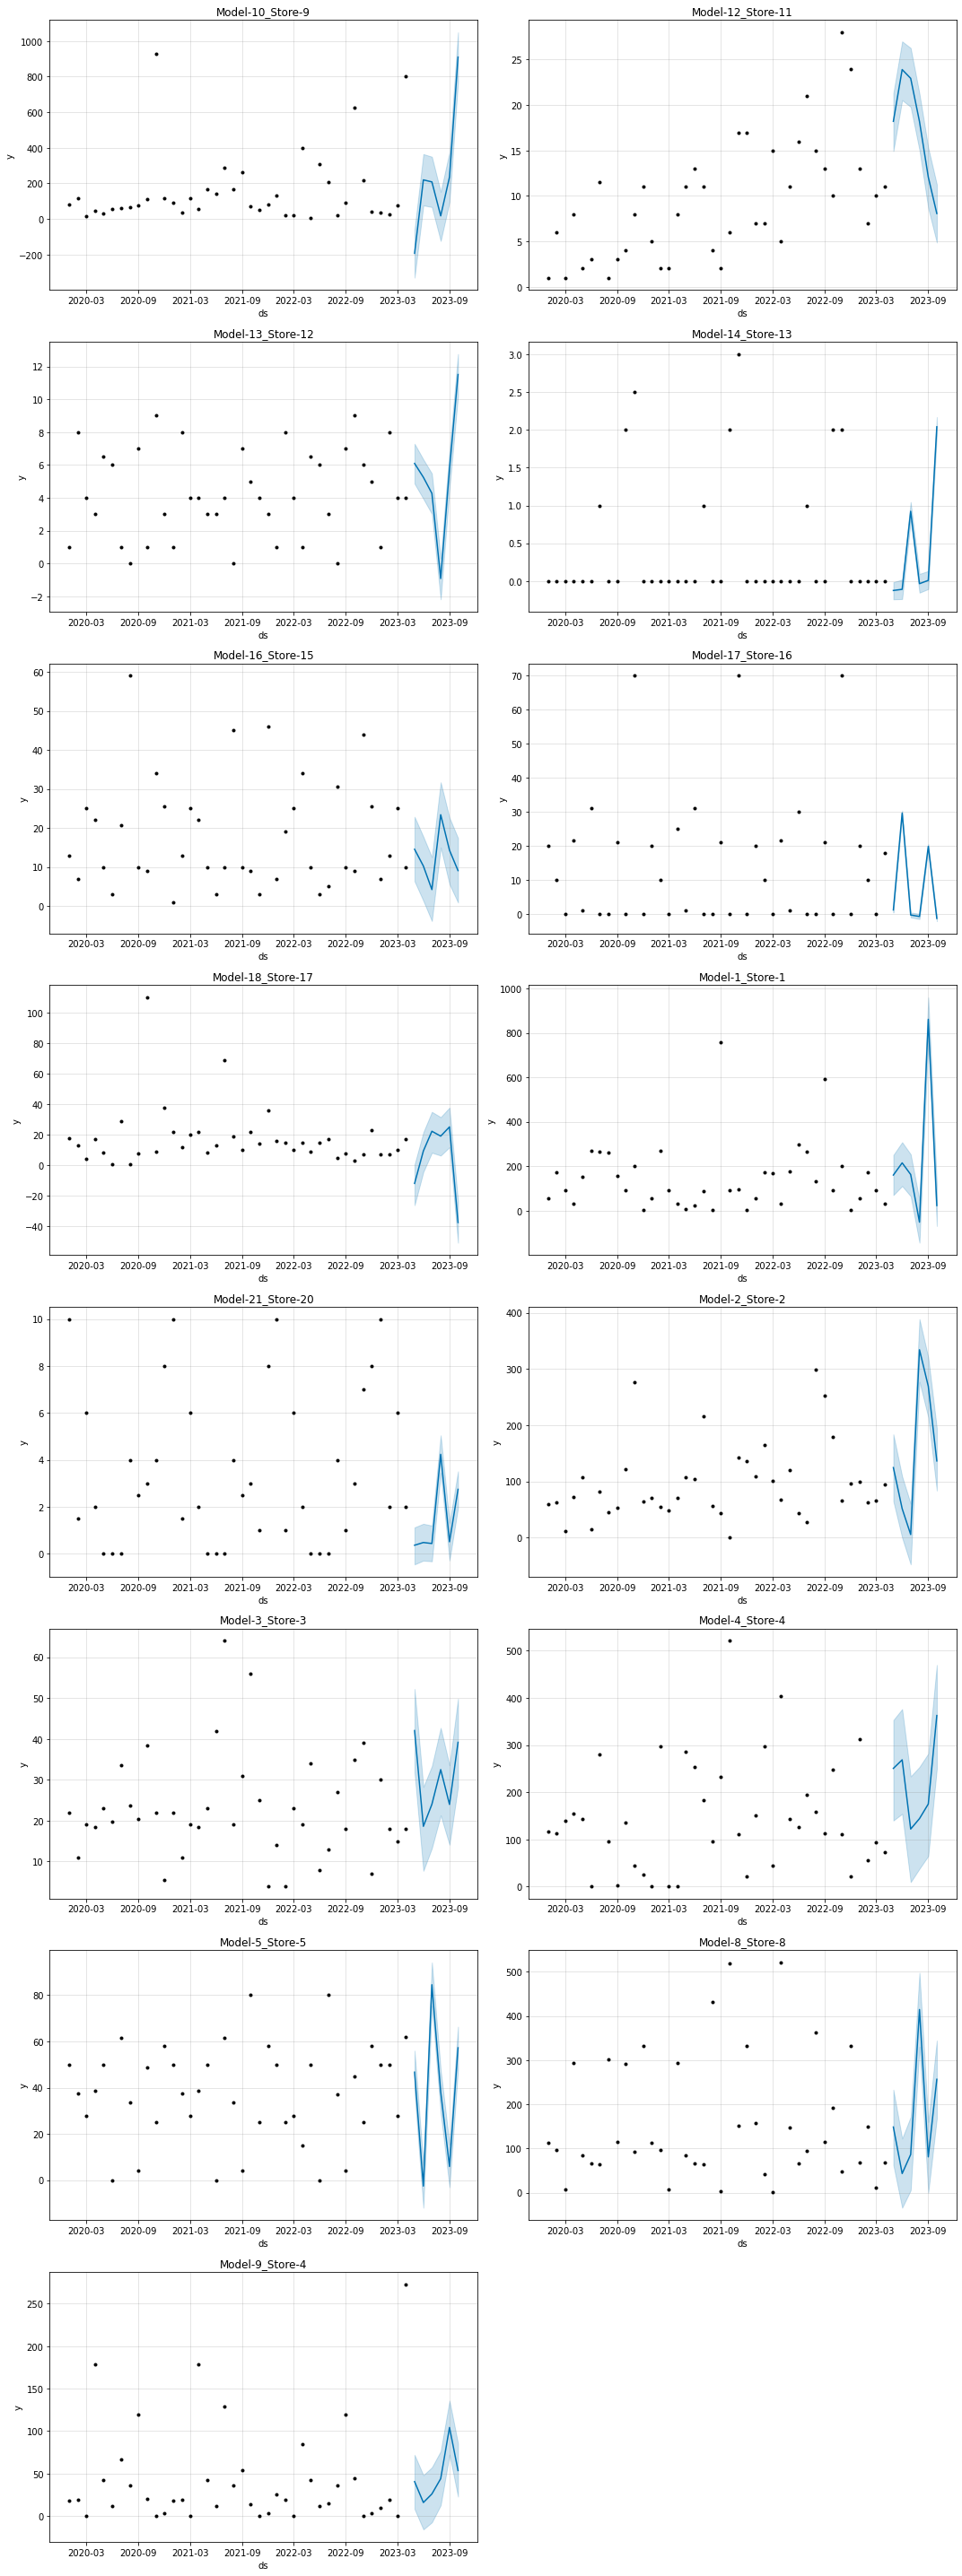

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Model_Store_Pair
0,2023-05-01,192.924195,-330.004166,-58.072816,192.924195,192.924195,-386.181098,-386.181098,-386.181098,-386.181098,-386.181098,-386.181098,0.0,0.0,0.0,-193.256903,Model-10_Store-9
1,2023-06-01,195.029719,76.117157,364.739459,195.029718,195.029719,24.726214,24.726214,24.726214,24.726214,24.726214,24.726214,0.0,0.0,0.0,219.755933,Model-10_Store-9
2,2023-07-01,197.067322,66.894741,349.845815,197.067321,197.067323,11.276053,11.276053,11.276053,11.276053,11.276053,11.276053,0.0,0.0,0.0,208.343375,Model-10_Store-9
3,2023-08-01,199.172845,-123.866158,152.341345,199.172844,199.172847,-181.879249,-181.879249,-181.879249,-181.879249,-181.879249,-181.879249,0.0,0.0,0.0,17.293597,Model-10_Store-9
4,2023-09-01,201.278369,95.391825,376.265962,201.278367,201.278371,34.464208,34.464208,34.464208,34.464208,34.464208,34.464208,0.0,0.0,0.0,235.742577,Model-10_Store-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2023-06-01,42.722253,-15.837758,48.070883,42.722248,42.722258,-26.835212,-26.835212,-26.835212,-26.835212,-26.835212,-26.835212,0.0,0.0,0.0,15.887041,Model-9_Store-4
2,2023-07-01,42.711794,-7.455250,57.333697,42.711784,42.711805,-16.737028,-16.737028,-16.737028,-16.737028,-16.737028,-16.737028,0.0,0.0,0.0,25.974766,Model-9_Store-4
3,2023-08-01,42.700987,12.689287,76.288718,42.700971,42.701004,1.305450,1.305450,1.305450,1.305450,1.305450,1.305450,0.0,0.0,0.0,44.006437,Model-9_Store-4
4,2023-09-01,42.690179,72.199329,135.907763,42.690157,42.690203,61.575275,61.575275,61.575275,61.575275,61.575275,61.575275,0.0,0.0,0.0,104.265454,Model-9_Store-4


In [318]:
# Get unique Model_Store_Pairs
unique_pairs = full_sales_df['Model_Store_Pair'].unique()
prophet_dict = {}
prophet_pred_list = []

num_pairs = len(unique_pairs)
num_rows = (num_pairs + 1) // 2  # Calculate the number of rows

fig, axs = pyplot.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

for i, pair in enumerate(unique_pairs):
    # Define the training and testing data by filtering full_sales_df using the Model_Store_Pair
    training_df_pair = training_df[training_df['Model_Store_Pair'] == pair]
    testing_df_pair = testing_df[testing_df['Model_Store_Pair'] == pair]

    # Remove the Model_Store_Pair column for Prophet
    train = training_df_pair.drop(columns='Model_Store_Pair')
    test = testing_df_pair.drop(columns='Model_Store_Pair')
   
    # Create and fit the Prophet model
    model = Prophet()
    model.fit(train)

    test['ds'] = to_datetime(test['ds'])
    
    # Make forecasts using the trained model
    forecast = model.predict(test)

    # Append each forecast to a list for later concatenation
    prophet_pred_list.append(forecast)

    # Store the forecast in the dictionary if needed for further analysis
    prophet_dict[pair] = forecast

    # Plotting the forecasts in subplots
    row = i // 2  # Row number for the subplot
    col = i % 2  # Column number for the subplot
    model.plot(forecast, ax=axs[row, col])
    axs[row, col].set_title(pair)

# Hide any empty subplots
for i in range(num_pairs, num_rows * 2):
    row = i // 2
    col = i % 2
    fig.delaxes(axs[row, col])


pyplot.tight_layout()
pyplot.show()


combined_forecast = pd.concat(prophet_pred_list)
combined_forecast['Model_Store_Pair'] = [pair for pair in unique_pairs for _ in range(len(testing_df[testing_df['Model_Store_Pair'] == pair]))]


display(combined_forecast)


In [319]:
testing_df['Predicted_Sales_Quantity'] = combined_forecast.reset_index(drop=True)['yhat']
testing_df

,ds,y,Model_Store_Pair,Predicted_Sales_Quantity
0,2023-05-01,72.0,Model-10_Store-9,-193.256903
1,2023-06-01,16.0,Model-10_Store-9,219.755933
2,2023-07-01,37.0,Model-10_Store-9,208.343375
3,2023-08-01,55.0,Model-10_Store-9,17.293597
4,2023-09-01,51.0,Model-10_Store-9,235.742577
...,...,...,...,...
85,2023-06-01,11.0,Model-9_Store-4,15.887041
86,2023-07-01,57.0,Model-9_Store-4,25.974766
87,2023-08-01,36.0,Model-9_Store-4,44.006437
88,2023-09-01,185.0,Model-9_Store-4,104.265454


In [320]:
y_test_prophet = testing_df['y']
pred_prophet= testing_df['Predicted_Sales_Quantity']

test_mae = mean_absolute_error(y_test_prophet, pred_prophet)
print(f'MAE: {test_mae:.4f}')

mape = mean_absolute_percentage_error(y_test_prophet, pred_prophet)
print(f'MAPE: {mape:.4f}%')

mse = mean_squared_error(y_test_prophet, pred_prophet)

rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

model_eval['Prophet'] = [test_mae,mape,rmse]

MAE: 60.9756
MAPE: 285.3284%
Root Mean Squared Error (RMSE): 135.5473


In [321]:
df_model_eval = pd.DataFrame(model_eval)
df_model_eval = df_model_eval.T.reset_index()
df_model_eval.columns = ['Model', 'MAE', 'MAPE', 'RMSE']
df_model_eval = df_model_eval.round({'MAE': 2, 'MAPE': 2, 'RMSE': 2})
df_model_eval.to_csv('model_eval.csv', index=False)  

df_model_eval

,Model,MAE,MAPE,RMSE
0,Linear Regression,36.09,296.96,71.81
1,Random Forest Regressor,41.55,269.74,83.40
2,Gradiant Boosting Regressor,42.98,283.33,87.86
3,XGBoost Regressor,39.70,235.30,82.76
4,Prophet,60.98,285.33,135.55


In [322]:
def get_test_rows(df_predict_next_months, test_months):
    '''
    Gets the last 6 months of data for each model store pair
    which was used for evaluating our model
    '''
    # Define the test date range
    test_end_date = df_predict_next_months['MONTH_YEAR'].max()
    test_start_date = test_end_date - timedelta(days=30 * test_months)

    # Extract the test rows
    test_rows = df_predict_next_months[(df_predict_next_months['MONTH_YEAR'] >= test_start_date) & (df_predict_next_months['MONTH_YEAR'] <= test_end_date)]

    return test_rows

In [323]:
test_rows = get_test_rows(df_supervised_all, 6)
test_rows

,Model_Store_Pair,MONTH_YEAR,QUANTITY,Model_Store_Pair_ID,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
40,Model-10_Store-9,2023-05-01,72.0,0,800.0,75.0,28.0,36.0,39.0,219.0,624.0,93.0,21.0,209.0,307.0,5.0
41,Model-10_Store-9,2023-06-01,16.0,0,72.0,800.0,75.0,28.0,36.0,39.0,219.0,624.0,93.0,21.0,209.0,307.0
42,Model-10_Store-9,2023-07-01,37.0,0,16.0,72.0,800.0,75.0,28.0,36.0,39.0,219.0,624.0,93.0,21.0,209.0
43,Model-10_Store-9,2023-08-01,55.0,0,37.0,16.0,72.0,800.0,75.0,28.0,36.0,39.0,219.0,624.0,93.0,21.0
44,Model-10_Store-9,2023-09-01,51.0,0,55.0,37.0,16.0,72.0,800.0,75.0,28.0,36.0,39.0,219.0,624.0,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,Model-9_Store-4,2023-06-01,11.0,14,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5,36.0,15.0,12.0
42,Model-9_Store-4,2023-07-01,57.0,14,11.0,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5,36.0,15.0
43,Model-9_Store-4,2023-08-01,36.0,14,57.0,11.0,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5,36.0
44,Model-9_Store-4,2023-09-01,185.0,14,36.0,57.0,11.0,42.0,273.0,0.0,19.0,10.0,3.0,0.0,45.0,119.5


In [324]:
test_rows.to_csv('test_rows.csv',index=False)

In [325]:
# Convert predictions_XGB to a list
# Based on analysis above XGboost Regressor is the selectd model for forcasting
predictions_list = predictions_XGB.tolist()

# Create a new DataFrame with selected columns from test_rows
df_test_results = test_rows[['Model_Store_Pair', 'MONTH_YEAR', 'QUANTITY', 'Model_Store_Pair_ID']]

# Add a new column 'pred_value' with the values from predictions_list
df_test_results['pred_value'] = predictions_list

df_test_results


,Model_Store_Pair,MONTH_YEAR,QUANTITY,Model_Store_Pair_ID,pred_value
40,Model-10_Store-9,2023-05-01,72.0,0,130.635513
41,Model-10_Store-9,2023-06-01,16.0,0,232.785965
42,Model-10_Store-9,2023-07-01,37.0,0,114.893974
43,Model-10_Store-9,2023-08-01,55.0,0,285.840149
44,Model-10_Store-9,2023-09-01,51.0,0,57.421574
...,...,...,...,...,...
41,Model-9_Store-4,2023-06-01,11.0,14,15.050172
42,Model-9_Store-4,2023-07-01,57.0,14,73.689758
43,Model-9_Store-4,2023-08-01,36.0,14,78.243065
44,Model-9_Store-4,2023-09-01,185.0,14,136.867188


In [326]:
df_test_results.to_csv('results.csv', index=False)

In [327]:
# Group the df_test_results DataFrame by 'Model_Store_Pair'
grouped = df_test_results.groupby('Model_Store_Pair')

# Create dictionaries to store the metrics
metrics = {
    'Model_Store_Pair': [],
    'MAE': [],
    'MAPE': [],
    'RMSE': []
}

# Iterate through each group
for model_store_pair, group in grouped:
    actual_values = group['QUANTITY']
    predicted_values = group['pred_value']
    
    # Calculate metrics
    mae = mean_absolute_error(actual_values, predicted_values)
    mape = mean_absolute_percentage_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
   
    # Store the results in the metrics dictionary
    metrics['Model_Store_Pair'].append(model_store_pair)
    metrics['MAE'].append(mae)
    metrics['MAPE'].append(mape)
    metrics['RMSE'].append(rmse)

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

metrics_df



,Model_Store_Pair,MAE,MAPE,RMSE
0,Model-10_Store-9,163.860432,619.158002,209.743284
1,Model-12_Store-11,5.833894,49.423472,8.701171
2,Model-13_Store-12,2.010131,29.363270,2.330452
3,Model-14_Store-13,0.088452,8.410931,0.106005
4,Model-16_Store-15,3.869544,56.473043,4.021596
5,Model-17_Store-16,0.966670,48.855530,1.093730
6,Model-18_Store-17,11.384325,350.437107,13.680771
7,Model-1_Store-1,113.315424,36.381583,162.678057
8,Model-21_Store-20,0.912377,37.064434,1.525698
9,Model-2_Store-2,63.552956,966.148993,85.309882


In [328]:
metrics_df.to_csv('metrics.csv',index=False)

In [329]:
sorted_metrics_df = metrics_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)
sorted_metrics_df

,Model_Store_Pair,MAE,MAPE,RMSE
0,Model-14_Store-13,0.088452,8.410931,0.106005
1,Model-21_Store-20,0.912377,37.064434,1.525698
2,Model-17_Store-16,0.966670,48.855530,1.093730
3,Model-13_Store-12,2.010131,29.363270,2.330452
4,Model-16_Store-15,3.869544,56.473043,4.021596
5,Model-3_Store-3,5.732434,39.440615,7.181633
6,Model-12_Store-11,5.833894,49.423472,8.701171
7,Model-18_Store-17,11.384325,350.437107,13.680771
8,Model-5_Store-5,12.493079,82.539046,20.720075
9,Model-9_Store-4,33.107294,544.192782,37.975618


In [330]:
#Requested Model/Store predictions 
sorted_metrics_df[sorted_metrics_df['Model_Store_Pair'].isin(model_store_pairs)].reset_index(drop=True)

,Model_Store_Pair,MAE,MAPE,RMSE
0,Model-14_Store-13,0.088452,8.410931,0.106005
1,Model-17_Store-16,0.966670,48.855530,1.093730
2,Model-16_Store-15,3.869544,56.473043,4.021596
3,Model-12_Store-11,5.833894,49.423472,8.701171
4,Model-2_Store-2,63.552956,966.148993,85.309882
5,Model-8_Store-8,94.771243,202.688321,119.496994
6,Model-1_Store-1,113.315424,36.381583,162.678057
7,Model-10_Store-9,163.860432,619.158002,209.743284


In [331]:
sorted_metrics_df.to_csv('metrics.csv', index=False)

In [332]:
unique_pairs = df_test_results['Model_Store_Pair'].unique()

plot_data = []

# Loop through each unique Model_Store_Pair and create a trace for each one
for unique_pair in unique_pairs:
    trace_actual = go.Scatter(
        x=df_test_results[df_test_results['Model_Store_Pair'] == unique_pair].index,
        y=df_test_results[df_test_results['Model_Store_Pair'] == unique_pair]['QUANTITY'],
        mode='lines+markers',
        name=f'Actual - {unique_pair}',
    )
    trace_pred = go.Scatter(
        x=df_test_results[df_test_results['Model_Store_Pair'] == unique_pair].index,
        y=df_test_results[df_test_results['Model_Store_Pair'] == unique_pair]['pred_value'],
        mode='lines+markers',
        name=f'Predicted - {unique_pair}',
    )
    
    plot_data.append(trace_actual)
    plot_data.append(trace_pred)

plot_layout = go.Layout(
    title='Predicted vs Actual Values',
    showlegend=True,  # Show the legend
)

fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)


## Predict Next Months

In [333]:
def forcasting(numMonths, model_store_pairs):

    '''
    Create df with the next 6 months for each model/store
    Inputs:
        Number of months to predict
        List with model/stores to predict in format Model-X/Store-X
    Output:
        Dataframe containt Model/Store, Month Year of next 6 months, Mode/Store ID
    '''

    # Define the start date for prediction
    start_date = '2023-11-01'
    num_prediction_months = numMonths

    # Initialize an empty list to store the data
    data = []

    # Create date ranges for the next 6 months
    current_date = datetime.strptime(start_date, '%Y-%m-%d')
    for _ in range(num_prediction_months):
        data.extend([(model_store_pair, current_date) for model_store_pair in model_store_pairs])
        current_date += relativedelta(months=1)

    # Create a DataFrame from the collected data
    columns = ['Model_Store_Pair', 'MONTH_YEAR']
    df_predict_next_months = pd.DataFrame(data, columns=columns)

    # Print the DataFrame
    df_predict_next_months.sort_values(by=['Model_Store_Pair','MONTH_YEAR'],inplace=True)

    df_predict_next_months.reset_index(drop=True)
    df_predict_next_months['Model_Store_Pair_ID'] = df_predict_next_months['Model_Store_Pair'].map(pair_id_mapping.set_index('Model_Store_Pair')['Pair_ID'])
    df_predict_next_months.reset_index(drop=True,inplace=True)
    return df_predict_next_months

model_store_pairs = ['Model-1/Store-1', 'Model-2/Store-2', 'Model-8/Store-8',
        'Model-10/Store-9', 'Model-14/Store-13', 'Model-12/Store-11',
        'Model-17/Store-16', 'Model-16/Store-15']

# Replace slash ("/") with underscore ("_") in model/store pairs
model_store_pairs = [pair.replace('/', '_') for pair in model_store_pairs]

#Enter number of future months to forcast
df_predict_next_months = forcasting(6 ,model_store_pairs)
df_predict_next_months

,Model_Store_Pair,MONTH_YEAR,Model_Store_Pair_ID
0,Model-10_Store-9,2023-11-01,0
1,Model-10_Store-9,2023-12-01,0
2,Model-10_Store-9,2024-01-01,0
3,Model-10_Store-9,2024-02-01,0
4,Model-10_Store-9,2024-03-01,0
5,Model-10_Store-9,2024-04-01,0
6,Model-12_Store-11,2023-11-01,1
7,Model-12_Store-11,2023-12-01,1
8,Model-12_Store-11,2024-01-01,1
9,Model-12_Store-11,2024-02-01,1


In [334]:
# Create an empty dictionary to store predictions for each Model-Store pair
pred_dict = {}

# Iterate through each Model-Store pair
for model_store_pair in model_store_pairs:   
    # Filter data for the current Model-Store pair
    df_predict_next_months_one_store_model = df_predict_next_months[df_predict_next_months['Model_Store_Pair'] == model_store_pair]
    one_store_model_supervised = df_supervised_all[df_supervised_all['Model_Store_Pair'] == model_store_pair]

    # Extract the last 12 months of QUANTITY values
    last_12_months = one_store_model_supervised['QUANTITY'].iloc[-1:-13:-1]
    num_new_columns = len(last_12_months)

    # Reset the index of the filtered DataFrame
    df_predict_next_months_one_store_model.reset_index(drop=True, inplace=True)

    # Iterate through each new column (lag_1, lag_2, etc.)
    for i in range(num_new_columns):
        new_column_name = f'lag_{i + 1}'
        values_to_add = last_12_months.iloc[i]

        # Update only the first row of the new column
        df_predict_next_months_one_store_model.at[0, new_column_name] = values_to_add

    # Initialize a list to store predicted values for this Model-Store pair
    pred_dict[model_store_pair] = []

    # Iterate through rows to make predictions
    for row in range(0, len(df_predict_next_months_one_store_model)):
        # Filter data for the current row
        x_new_data = df_predict_next_months_one_store_model[df_predict_next_months_one_store_model['MONTH_YEAR'] == df_predict_next_months_one_store_model['MONTH_YEAR'].iloc[row]]
        
        # Remove unnecessary columns
        x_new_data.drop(columns=['Model_Store_Pair', 'MONTH_YEAR'], inplace=True)
        
        # Predict the next value using the XGBoost model
        predicted_values = model_XGB.predict(x_new_data)
        pred_dict[model_store_pair].append(predicted_values[0])

        # Check if there are predictions before updating columns
        if predicted_values.shape[0] > 0:
            # Update the first column (lag_1) with the predicted value
            df_predict_next_months_one_store_model.at[row + 1, 'lag_1'] = predicted_values[0]
            
            # Iterate through the rest of the columns (lag_2, lag_3, etc.)
            for i in range(2, num_new_columns + 1):
                new_column_name = f'lag_{i}'
                
                # Use the values from the previous row for the rest of the columns
                df_predict_next_months_one_store_model.at[row + 1, new_column_name] = df_predict_next_months_one_store_model.at[row, f'lag_{i - 1}']
        else:
            # If there are no more predictions, break the loop
            break

# The pred_dict dictionary now contains predictions for each Model-Store pair
pred_dict


{'Model-1_Store-1': [146.97368,
  21.369793,
  53.6424,
  252.64339,
  91.07827,
  47.71229],
 'Model-2_Store-2': [152.81729,
  92.42625,
  93.31343,
  100.59378,
  129.68753,
  94.049835],
 'Model-8_Store-8': [79.25937,
  260.82758,
  59.630356,
  101.07047,
  15.85462,
  43.791546],
 'Model-10_Store-9': [75.84181,
  60.239594,
  127.87543,
  201.08344,
  110.716286,
  148.91354],
 'Model-14_Store-13': [2.535779,
  0.049796127,
  0.14377365,
  -0.10107544,
  -0.035939723,
  -0.060170785],
 'Model-12_Store-11': [42.500637,
  19.725054,
  18.26205,
  17.927818,
  16.765617,
  13.696153],
 'Model-17_Store-16': [66.03283,
  27.763283,
  21.806387,
  8.413145,
  12.416863,
  16.695513],
 'Model-16_Store-15': [5.8218307,
  23.128183,
  1.11953,
  12.825882,
  20.989855,
  11.925821]}

In [335]:
# Iterate through the Model-Store pairs in pred_dict
for model_store_pair, predicted_values in pred_dict.items():
    # Filter rows in df_predict_next_months that match the current Model-Store pair
    mask = (df_predict_next_months['Model_Store_Pair'] == model_store_pair)
    
    # Assign the predicted values to the corresponding rows in df_predict_next_months
    df_predict_next_months.loc[mask, 'Predicted_Sales_Quantity'] = predicted_values

df_predict_next_months

,Model_Store_Pair,MONTH_YEAR,Model_Store_Pair_ID,Predicted_Sales_Quantity
0,Model-10_Store-9,2023-11-01,0,75.841812
1,Model-10_Store-9,2023-12-01,0,60.239594
2,Model-10_Store-9,2024-01-01,0,127.875427
3,Model-10_Store-9,2024-02-01,0,201.083435
4,Model-10_Store-9,2024-03-01,0,110.716286
5,Model-10_Store-9,2024-04-01,0,148.913544
6,Model-12_Store-11,2023-11-01,1,42.500637
7,Model-12_Store-11,2023-12-01,1,19.725054
8,Model-12_Store-11,2024-01-01,1,18.262051
9,Model-12_Store-11,2024-02-01,1,17.927818


In [336]:
df_predict_next_months.to_csv('next_months_pred.csv', index=False)

In [337]:
# Get unique Model_Store_Pairs
unique_pairs = df_predict_next_months['Model_Store_Pair'].unique()

# Create an empty list to store traces
plot_data = []

# Loop through each unique Model_Store_Pair and create a trace
for unique_pair in unique_pairs:
    trace = go.Scatter(
        x=df_predict_next_months[df_predict_next_months['Model_Store_Pair'] == unique_pair]['MONTH_YEAR'],
        y=df_predict_next_months[df_predict_next_months['Model_Store_Pair'] == unique_pair]['Predicted_Sales_Quantity'],
        mode='lines+markers', 
        name=unique_pair  # Label each trace with the Model_Store_Pair
    )
    plot_data.append(trace)

plot_layout = go.Layout(
    title='Monthly Sales'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

